In [9]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patches as patches
import numpy as np
import shapely

In [10]:
site_file = "/resnick/groups/enceladus/glavrent/Scalable_GPs/Raw_files/scec/study_22.12_sites.csv"
sites_gdf = pd.read_csv(site_file)
sites_gdf = gpd.GeoDataFrame(
    sites_gdf, geometry=gpd.points_from_xy(sites_gdf['site_lon'], sites_gdf['site_lat'])
)
sites_gdf.crs = "EPSG:4326"
sites_gdf = sites_gdf.to_crs("EPSG:32711")

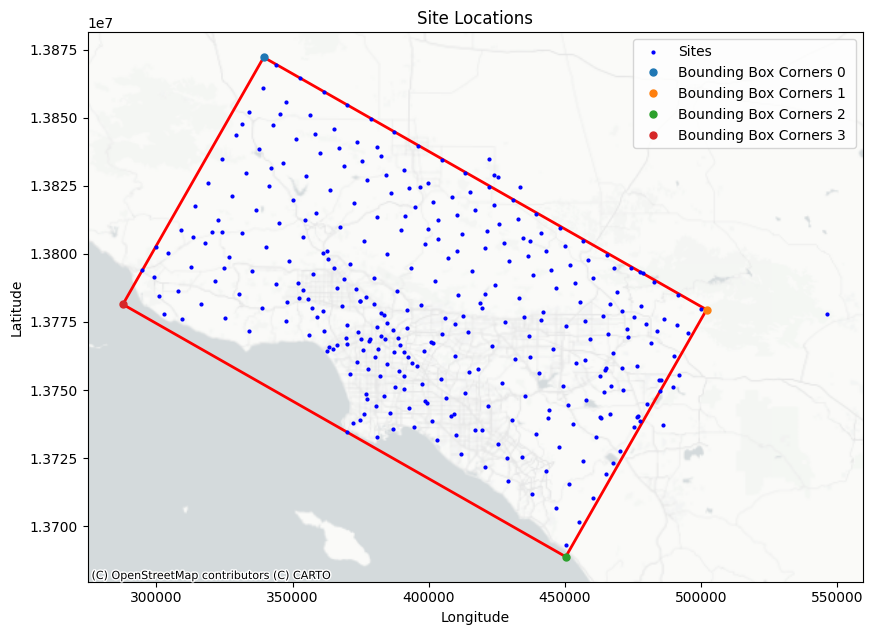

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
sites_gdf.plot(ax=ax, color='blue', markersize=4, label='Sites', zorder=2)  # Blue points for sites
# Bounding box
sites_to_consider = sites_gdf[~sites_gdf['site_id'].isin(['PTWN','BKBU',
        'LBUT','LBUT2','PIBU', 'NUEVO','s794', 's795'])]
# Get the minimum rotated rectangle for the GeoDataFrame
min_rot_rect = sites_to_consider.union_all().minimum_rotated_rectangle
# Plot the smallest bounding rectangle (minimum rotated rectangle)
x, y = min_rot_rect.exterior.xy
ax.plot(x, y, color='red', linestyle='-', linewidth=2, zorder=1)  # Red line for the bounding box

ax.plot(x[0], y[0], 'o', markersize=5, label='Bounding Box Corners 0 ', zorder=3)  # Red points for corners
ax.plot(x[1], y[1], 'o', markersize=5, label='Bounding Box Corners 1 ', zorder=3)  # Red points for corners
ax.plot(x[2], y[2], 'o', markersize=5, label='Bounding Box Corners 2 ', zorder=3)  # Red points for corners
ax.plot(x[3], y[3], 'o', markersize=5, label='Bounding Box Corners 3 ', zorder=3)  # Red points for corners
ax.set_title('Site Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ctx.add_basemap(ax, crs=sites_gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
ax.legend()

Length of the bottom-left edge of the bounding box: 104.38 km
Length of the bottom-left edge of the bounding box: 187.10 km
Length of the bottom-right edge of the bounding box: 105.38 km


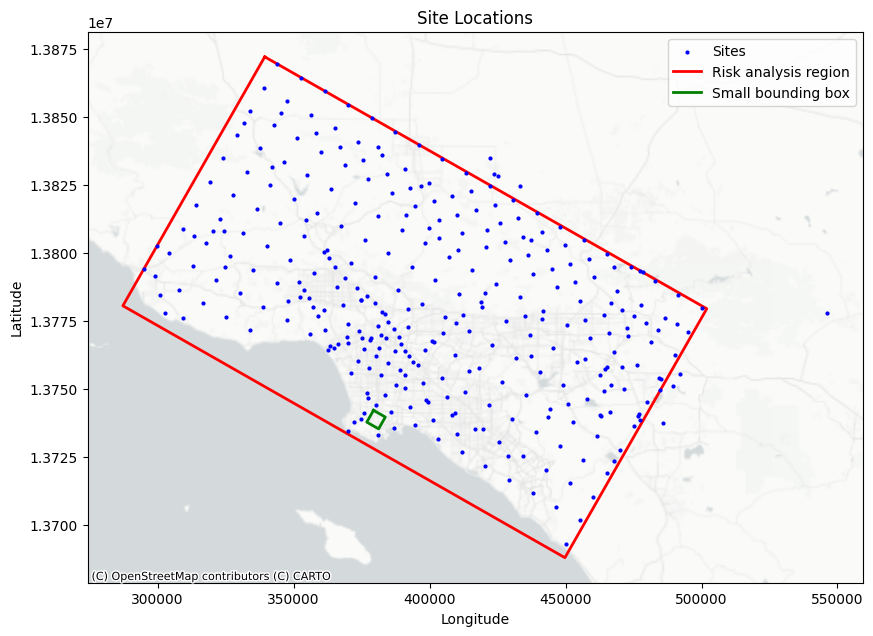

In [ ]:
length_of_bl_edge = np.sqrt((x[2] - x[1])**2 + (y[2] - y[1])**2)
print(f"Length of the bottom-left edge of the bounding box: {length_of_bl_edge/1000:.2f} km")
x_new = np.array([x[0], x[1], x[2], x[3], x[4]])
y_new = np.array([y[0], y[1], y[2], y[3], y[4]])
x_small = np.array([x[0], x[1], x[2], x[3], x[4]])
y_small = np.array([y[0], y[1], y[2], y[3], y[4]])
# extend the bottom vertice by 1 km
x_new[2] += (x[2] - x[1]) / length_of_bl_edge * 1000
y_new[2] += (y[2] - y[1]) / length_of_bl_edge * 1000
# extend the left vertice by 1 km
x_new[3] += (x[3] - x[4]) / length_of_bl_edge * 1000
y_new[3] += (y[3] - y[4]) / length_of_bl_edge * 1000

x_small[1] -= (x[1] - x[0]) / 187.1 * (187.1-2)
y_small[1] -= (y[1] - y[0]) / 187.1 * (187.1-2)
x_small[2] -= (x[2] - x[3]) / 187.1 * (187.1-2)
y_small[2] -= (y[2] - y[3]) / 187.1 * (187.1-2)
x_small[2] -= (x[2] - x[1]) / 104.4 * (104.4-2)
y_small[2] -= (y[2] - y[1]) / 104.4 * (104.4-2)
x_small[3] -= (x[3] - x[4]) / 104.4 * (104.4-2)
y_small[3] -= (y[3] - y[4]) / 104.4 * (104.4-2)
for i in range(len(x_small)):
    x_small[i] += 40000
for i in range(len(y_small)):
    y_small[i] -= 130000

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sites_gdf.plot(ax=ax, color='blue', markersize=4, label='Sites', zorder=2)  # Blue points for sites
# Bounding box
ax.plot(x_new, y_new, color='red', linestyle='-', linewidth=2, zorder=1, label='Risk analysis region')  # Red line for the bounding box
ax.plot(x_small, y_small, color='green', linestyle='-', linewidth=2, zorder=1, label='Small bounding box')  # Green line for the small bounding box
# ax.plot(x, y, color='green', linestyle='-', linewidth=2, zorder=1)  # Red line for the bounding box
ax.set_title('Site Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ctx.add_basemap(ax, crs=sites_gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
ax.legend()

length_of_bl_edge = np.sqrt((x_new[3] - x_new[2])**2 + (y_new[3] - y_new[2])**2)
print(f"Length of the bottom-left edge of the bounding box: {length_of_bl_edge/1000:.2f} km")
length_of_br_edge = np.sqrt((x_new[2] - x_new[1])**2 + (y_new[2] - y_new[1])**2)
print(f"Length of the bottom-right edge of the bounding box: {length_of_br_edge/1000:.2f} km")

In [13]:
# Create a GeoDataFrame to store the rectangle
extended_rect = shapely.geometry.Polygon(zip(x_new, y_new))
rect_gdf = gpd.GeoDataFrame(geometry=[extended_rect], crs=sites_gdf.crs)
rect_gdf = rect_gdf.to_crs("EPSG:4326")  # Convert to WGS84 for GeoJSON compatibility
# Save the GeoDataFrame as a GeoJSON file
rect_gdf.to_file('risk_region.geojson', driver='GeoJSON')

small_rect = gpd.GeoDataFrame(geometry=[shapely.geometry.Polygon(zip(x_small, y_small))], crs=sites_gdf.crs)
small_rect = small_rect.to_crs("EPSG:4326")  # Convert to WGS84 for GeoJSON compatibility
# Save the GeoDataFrame as a GeoJSON file
small_rect.to_file('small_risk_region.geojson', driver='GeoJSON')

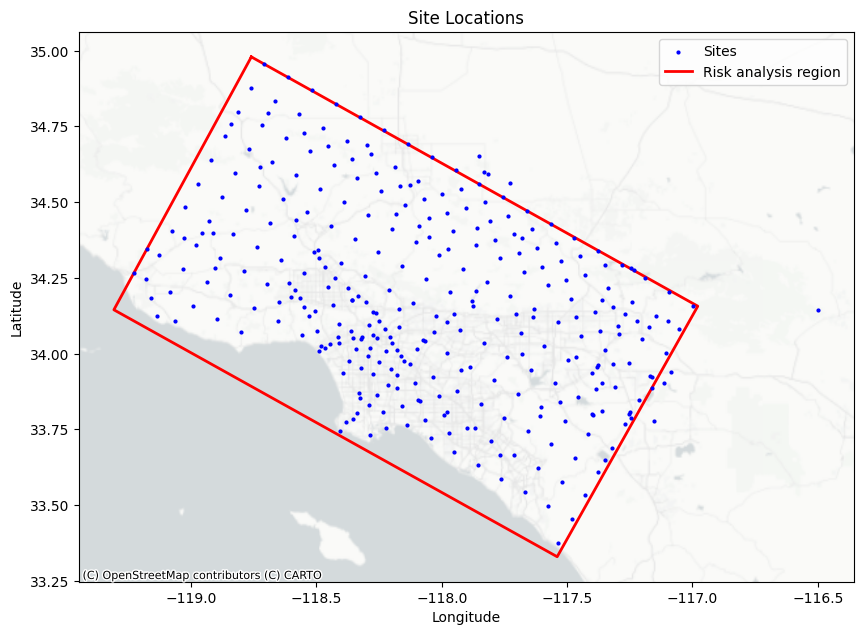

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sites_gdf = sites_gdf.to_crs("EPSG:4326")  # Convert to WGS84 for plotting
sites_gdf.plot(ax=ax, color='blue', markersize=4, label='Sites', zorder=2)  # Blue points for sites
# Bounding box
x_plot, y_plot = rect_gdf.geometry[0].exterior.xy
ax.plot(x_plot, y_plot, color='red', linestyle='-', linewidth=2, zorder=1, label='Risk analysis region')  # Red line for the bounding box
# ax.plot(x, y, color='green', linestyle='-', linewidth=2, zorder=1)  # Red line for the bounding box
ax.set_title('Site Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ctx.add_basemap(ax, crs=sites_gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
ax.legend()